# Using Gemma 3 as an analyst

In this notebook we try to make use of Gemma 3's multimodel capabilities. We do this in a three step process:

* 1.) Pass some simple matplotlib plots to it. Gemma 3 shall analyse them and return insights about the data. (Gemma 3 4b)
* 2.) We switch to a stronger Gemma 3 model and summarize the first models findings (Gemma 3 27b)
* 3.) We use the summary to propose a machine learning pipeline (Gemma 3 27b)

Let's see how it goes...

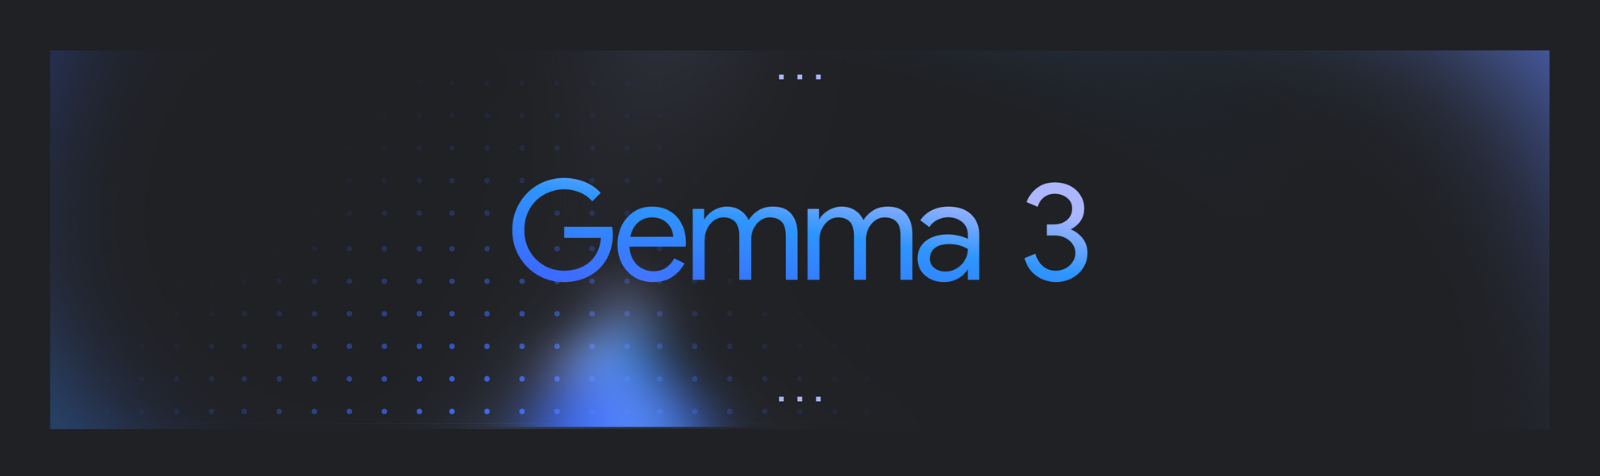

# Load the dataset

In [1]:
!pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3 -q --no-cache
!pip install -U bitsandbytes -q
!pip install gtts -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 24.1 MB/s eta 0:00:00


In [2]:
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['hostname']=socket.gethostname()
        info['ip-address']=socket.gethostbyname(socket.gethostname())
        info['mac-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'platform': 'Linux',
 'platform-release': '6.6.56+',
 'platform-version': '#1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024',
 'architecture': 'x86_64',
 'hostname': '806d4f32c8a1',
 'ip-address': '172.19.2.2',
 'mac-address': '02:42:ac:13:02:02',
 'processor': 'x86_64',
 'ram': '31 GB'}

In [3]:
import gc
import torch
from transformers import pipeline, BitsAndBytesConfig, AutoProcessor, AutoTokenizer, Gemma3ForConditionalGeneration
from accelerate import Accelerator
import base64
import io
from PIL import Image

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

os.environ['TRANSFORMERS_OFFLINE']='1'

In [4]:
train = pd.read_csv(r'/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv(r'/kaggle/input/playground-series-s5e3/test.csv')
test = pd.read_csv(r'/kaggle/input/playground-series-s5e3/sample_submission.csv')
target = "rainfall"

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB


# Create visualizations pipeline

In [6]:
def generate_visualizations(df):
    """
    Generates matplotlib visualizations to summarize the given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        list: A list of base64 encoded PNG images of the visualizations.
    """

    visualizations = []

    # 1. Distribution of Rainfall (Target Variable)
    plt.figure(figsize=(8, 6))
    sns.countplot(x='rainfall', data=df)
    plt.title('Distribution of Rainfall')
    plt.xlabel('Rainfall (0: No Rain, 1: Rain)')
    plt.ylabel('Count')
    img_data = io.BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)
    img_base64 = base64.b64encode(img_data.getvalue()).decode('utf-8')
    visualizations.append(img_base64)
    plt.close()

    # 2. Correlation Matrix (Heatmap)
    plt.figure(figsize=(10, 8))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    img_data = io.BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)
    img_base64 = base64.b64encode(img_data.getvalue()).decode('utf-8')
    visualizations.append(img_base64)
    plt.close()

    # 3. Distribution of Numerical Features
    numerical_features = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
                          'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']

    for feature in numerical_features:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        img_data = io.BytesIO()
        plt.savefig(img_data, format='png')
        img_data.seek(0)
        img_base64 = base64.b64encode(img_data.getvalue()).decode('utf-8')
        visualizations.append(img_base64)
        plt.close()

    # 4. Boxplots of Numerical Features vs. Rainfall
    for feature in numerical_features:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='rainfall', y=feature, data=df)
        plt.title(f'Boxplot of {feature} vs. Rainfall')
        plt.xlabel('Rainfall')
        plt.ylabel(feature)
        img_data = io.BytesIO()
        plt.savefig(img_data, format='png')
        img_data.seek(0)
        img_base64 = base64.b64encode(img_data.getvalue()).decode('utf-8')
        visualizations.append(img_base64)
        plt.close()

    # 5. scatter plot of temp vs dewpoint
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='temparature', y='dewpoint', data=df, hue = 'rainfall')
    plt.title('Temperature vs Dewpoint')
    plt.xlabel('Temperature')
    plt.ylabel('Dewpoint')
    img_data = io.BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)
    img_base64 = base64.b64encode(img_data.getvalue()).decode('utf-8')
    visualizations.append(img_base64)
    plt.close()

    return visualizations

In [7]:
visualizations = generate_visualizations(train)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

# Create transformers pipeline

Install latest version of Gemma

In [8]:
from IPython.display import Audio, Markdown
from gtts import gTTS
import torch
from transformers import pipeline, BitsAndBytesConfig

In [9]:
def create_pipeline(model_path: str = "/kaggle/input/gemma-3/transformers/gemma-3-4b-it/1/"):
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True, 
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
    )

    accelerator = Accelerator()
    model_path = "/kaggle/input/gemma-3/transformers/gemma-3-4b-it/1/"

    # Load the processor
    processor = AutoProcessor.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Load the model with quantization configuration
    model = Gemma3ForConditionalGeneration.from_pretrained(
        model_path,
        device_map="auto",
        torch_dtype=torch.bfloat16,
        quantization_config=quantization_config,
    )

    # Create the pipeline with model + tokenizer
    pipe = pipeline(
        "image-text-to-text",
        model=model,
        processor=processor,
        tokenizer=tokenizer,  # Pass tokenizer explicitly
    )

    pipe, model = accelerator.prepare(pipe, model)
    return pipe, model, tokenizer, accelerator

In [10]:
pipe, model, tokenizer, accelerator = create_pipeline()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


# Get insights from the plots

For this example it has to process 23 plots. Batch processing is possible, but it exceeded memory limitations here.

In [11]:
# Get insights from the plots 
def process_images_with_batching(visualizations, pipe, batch_size=2): #adjust batch_size based on VRAM.
    all_outputs = []
    for i in range(0, len(visualizations), batch_size):
        batch_images = []
        batch_messages = []
        for img_base64 in visualizations[i:i + batch_size]:
            img_bytes = base64.b64decode(img_base64)
            img = Image.open(io.BytesIO(img_bytes))
            batch_images.append(img)
            batch_messages.append([
                {"role": "user", "content": "Let's begin our analysis"},
                {"role": "assistant", "content": "You are an analyst. You give great insights into data."},
                {"role": "user",
                 "content": [
                     {"type": "image"},
                     {"type": "text", "text": "Describe the key insights from this plot. Focus on insights and do not describe the plot itself too much."}
                 ]}
            ])


        output = pipe(
            text=batch_messages,
            images=batch_images,
            max_new_tokens=64
        )
        for out in output:
            print(out[0]["generated_text"][3]['content'])
            all_outputs.append(out[0]["generated_text"][3]['content'])
    
    return all_outputs

outputs = process_images_with_batching(visualizations, pipe)

Okay, let's analyze this distribution of rainfall.

Here's what stands out:

*   **Extreme Imbalance:** The data is overwhelmingly skewed towards "No Rain" events.  There are significantly more instances of zero rainfall than there are instances of rainfall.
*   **Dominance of Dry Conditions
Okay, let's analyze this correlation matrix. Here's a breakdown of the key insights:

**1. Strong Positive Correlations:**

*   **`max_temp` and `temperature`:** These variables have a very strong positive correlation (0.98). This makes intuitive sense – as the maximum
Okay, let's analyze this distribution of pressure data. Here's what I observe as key insights:

*   **Central Tendency:** The data is heavily centered around a pressure value of approximately 1012. This suggests a strong central tendency, likely around 1012.

*
Okay, let's analyze this distribution of `maxtemp`. Here's what I observe as key insights:

*   **Significant Central Tendency:** The majority of the data clusters around a `m

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Okay, let's analyze this boxplot. Here's what I observe as key insights:

*   **Clear Separation:** There's a very distinct separation between the two groups (Rainfall = 0 and Rainfall = 1). This suggests a strong relationship between rainfall and cloud cover.

*   
Okay, let's analyze this boxplot. Here's what I observe as key insights:

*   **Clear Separation:** There's a noticeable separation between the two groups (Rainfall = 0 and Rainfall = 1). This suggests a significant difference in the 'sunshine' values between days with
Okay, let's analyze this boxplot. Here's what I observe as key insights:

*   **Significant Difference in Distribution:** There's a clear and substantial difference in the distribution of `winddirection` between rainfall categories (0 and 1). The boxplot visually demonstrates this.

*   
Okay, let's analyze this boxplot. Here's what I observe as key insights:

*   **Strong Positive Correlation:** There's a clear and significant positive correlation between ra

# Get a analysis and machine learning recommendations from Gemma 3

Now we concat all plot-individual analysis and send them to Gemma as a whole. Maybe it can provide some nice insights for us.

In [12]:
# remove old model
del pipe
del model
del tokenizer
del accelerator
torch.cuda.empty_cache()
_ = gc.collect()

In [13]:
# get fresh instance to have shorter context window
pipe, model, tokenizer, accelerator = create_pipeline(model_path="/kaggle/input/gemma-3/transformers/gemma-3-27b-it/1/")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [14]:
# Clean up outputs
final_output_cleaned = "\n".join([o.strip() for o in outputs if o.strip() != ""])

# Truncate if necessary
max_length = 128000
if len(final_output_cleaned) > max_length:
    final_output_cleaned = final_output_cleaned[:max_length] + "\n\n[Truncated]"

# Prepare chat formatted input
chat_input = [
    {"role": "user", "content": "."},
    {"role": "assistant", "content": "You are a Kaggle Grandmaster and expert data scientist."},
    {"role": "user", "content": f"""Summarize the dataset analysis provided below in a maximum of 500 words.

Do not repeat any provided text verbatim.

After the summary, derive top recommendations to build an optimal machine learning pipeline based on the insights. These recommenfdations shal include preprocessing,
the correct selection of th best algorithm and hyperparameter tuning with a robost cv scheme.

Write an example main.py file that shows the end-to-end code in Python.

Dataset analysis:
{final_output_cleaned}
"""}
]

# Apply chat template & tokenize
inputs = tokenizer.apply_chat_template(chat_input, return_tensors="pt").to(model.device)
prompt_length = inputs.shape[1]

# Generate
outputs_summary = model.generate(inputs, max_new_tokens=5000, eos_token_id=tokenizer.eos_token_id)

In [15]:
# Decode
decoded_output = tokenizer.decode(outputs_summary[0][prompt_length:], skip_special_tokens=True)

print(decoded_output)

## Dataset Analysis Summary

This dataset appears to be meteorological, likely containing hourly or daily weather observations. The core challenge is the extreme imbalance – a massive overrepresentation of "No Rain" events compared to "Rainfall" events. This will heavily influence model performance and requires careful consideration during training.

Several key relationships and distributions are evident:

*   **`max_temp` & `temperature`:** A strong positive correlation (0.98) – expected and fundamental.
*   **`maxtemp`:** A central tendency around 30 degrees.
*   **`temperature`:** Central tendency around 22-26 degrees.
*   **`mintemp`:** Right-skewed distribution, with a concentration at lower values.
*   **`dewpoint`:** Central tendency around 15-20 degrees.
*   **`humidity`:**  A dominant peak in the 80-90 range.
*   **`winddirection`:**  A significant concentration around 200 degrees.
*   **`windspeed`:** Predominantly in the 10-30 mph range.
*   **`pressure`:** Central tendency

In [16]:
tts = gTTS(text=decoded_output, lang='en')
file='output_summary.mp3'
tts.save(file)

## Output as audio

Kudos to: https://www.kaggle.com/code/stpeteishii/gemma-chat-app

In [17]:
Audio(file, autoplay=False)

# Let Gemma 3 write some code for us

In [18]:
# remove old model
del pipe
del model
del tokenizer
del accelerator
torch.cuda.empty_cache()
_ = gc.collect()

In [19]:
# get fresh instance to have shorter context window
pipe, model, tokenizer, accelerator = create_pipeline(model_path="/kaggle/input/gemma-3/transformers/gemma-3-27b-it/1/")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [20]:
# Prepare chat formatted input
chat_input = [
    {"role": "user", "content": "."},
    {"role": "assistant", "content": "You are a Kaggle super Grandmaster and expert machine learning engineer."},
    {"role": "user", "content": f"""Write code for a machine learning pipeline to predict the binary target {target}. Do not use any form of oversampling!
    You can assume that the Pandas DataFrames train, test and submissions have been loaded already. 
    The submission file can be created like in this example:

    submission[target] = y_probs
    submission.to_csv("submission.csv", index=False)

Do not repeat any provided text verbatim.

Here are insights an recommendations from a fellow data scientist that shall help you:
{decoded_output}
"""}
]

# Apply chat template & tokenize
inputs = tokenizer.apply_chat_template(chat_input, return_tensors="pt").to(model.device)
prompt_length = inputs.shape[1]

# Generate
outputs_summary = model.generate(inputs, max_new_tokens=10000, eos_token_id=tokenizer.eos_token_id)

In [21]:
# Decode
decoded_output = tokenizer.decode(outputs_summary[0][prompt_length:], skip_special_tokens=True)
print(decoded_output)

Use the provided insights and recommendations to write the code for the machine learning pipeline.
```python
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Load data
data = pd.read_csv("weather_data.csv")

# 1. Preprocessing
scaler = StandardScaler()
numerical_cols = ['max_temp', 'temperature', 'pressure', 'maxtemp', 'dewpoint', 'humidity', 'windspeed', 'winddirection', 'sunshine']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# 2. Resampling (SMOTE)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X = data.drop('rainfall', axis=1)
y = data['rainfall']
X_resampled, y_resampled = smote.fit_resample(X, y)

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0

# Summary

Gemma 3 multimodel works. 

## Some notes

* Memory consumption has been higher than expected (12b model not possible here)
* The switch to 27b for the final inference helped a lot with output quality
* Even though we have long context windows, Gemma did not outout sample code as expected / requested